In [54]:
using TestImages, Images, ImageView, Colors, ImageFiltering


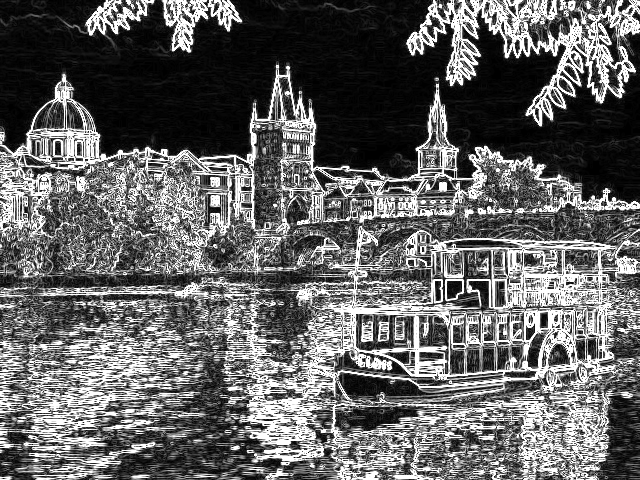

In [73]:
img=testimage("lighthouse")
img=load("./inputSeamCarvingPrague.jpg")
gray=Gray.(img)
kernel=centered([1 0 -1;2 0 -2;1 0 -1])
sobel_x=imfilter(gray, kernel)
sobel_y=imfilter(gray, kernel')

#energy=imfilter(gray, Kernel.Laplacian())
sobelx=convert(Array{Float64, 2},sobel_x)
sobely=convert(Array{Float64,2}, sobel_y)
energy=sqrt.(sobelx.^2+sobely.^2)
#energy=convert(Array{Float64, 2}, energy)
#energy=energy.^2
Gray.(energy)
#gray=convert(Array{Gray}, img)
#Gx_, Gy_=imgradients(gray, "sobel")
#energy=sqrt(Gx_.^2+Gy_.^2)

In [74]:
energy

480×640 Array{Float64,2}:
 0.0372033  0.0526134  0.0649135  …  0.504314   0.440963   0.329458 
 0.0824463  0.0944439  0.107683      1.18869    1.07107    0.969461 
 0.0627451  0.0627451  0.0646762     0.955319   1.78708    1.39847  
 0.0313725  0.0277297  0.0277297     1.05285    1.82401    1.93095  
 0.0156863  0.0175378  0.0298658     1.40629    1.26933    2.31478  
 0.0156863  0.0124011  0.0277297  …  0.797729   0.437286   1.09407  
 0.0589541  0.0477079  0.0298658     0.361296   0.266724   0.307487 
 0.051131   0.0599885  0.0627451     1.43691    0.0579012  0.0754329
 0.0110919  0.0277297  0.0477079     1.32803    1.0112     0.160832 
 0.0166378  0.0124011  0.0124011     0.355113   1.49878    0.498425 
 0.0433151  0.0355113  0.0235294  …  1.48114    0.667566   1.41508  
 0.0746129  0.0632334  0.0496044     1.17025    0.803108   1.15763  
 0.0599885  0.0526134  0.0447128     0.288602   1.38379    0.833183 
 ⋮                                ⋱                                 
 0.07543

In [75]:
function cumulative_minimum_energy_map(energy)
    (height, width)=size(energy)
    cumulativeEnergyMap=SharedArray{Float64, 2}(height, width)
    cumulativeEnergyMap=energy
    for j=2:width
        Threads.@threads for i=1:height
                if i==1
                    cumulativeEnergyMap[i,j]=cumulativeEnergyMap[i,j]+min(cumulativeEnergyMap[i, j-1], cumulativeEnergyMap[i+1, j-1])
                elseif i==height
                    cumulativeEnergyMap[i,j]=cumulativeEnergyMap[i,j]+min(cumulativeEnergyMap[i, j-1], cumulativeEnergyMap[i-1, j-1])
                else
                    cumulativeEnergyMap[i,j]=cumulativeEnergyMap[i,j]+min(cumulativeEnergyMap[i-1,j-1], cumulativeEnergyMap[i, j-1], cumulativeEnergyMap[i+1, j-1])
                end
            end
    end
    return cumulativeEnergyMap
end

cumulative_minimum_energy_map (generic function with 1 method)

In [76]:
cumulativeEnergyMap = cumulative_minimum_energy_map(energy)



480×640 Array{Float64,2}:
 0.0372033  0.0898166  0.15473    …  44.1626  44.4331  44.874   45.2035
 0.0824463  0.131647   0.197499      43.9288  44.7298  45.5041  45.8435
 0.0627451  0.0941176  0.108092      43.5411  44.4964  46.2835  46.9026
 0.0313725  0.0434159  0.0609537     43.6862  44.5939  46.3204  47.7942
 0.0156863  0.0332241  0.0579531     44.3087  45.0924  45.8633  47.2294
 0.0156863  0.0280874  0.055817   …  44.1161  44.9138  44.9146  45.8381
 0.0589541  0.0633942  0.0579531     45.5282  44.4774  44.7441  44.8427
 0.051131   0.0710803  0.101567      44.4297  45.8666  44.5353  44.6107
 0.0110919  0.0388215  0.0712009     45.2559  45.7578  46.6222  44.6961
 0.0166378  0.023493   0.035894      48.9501  45.611   47.1098  46.3506
 0.0433151  0.0521491  0.0470224  …  47.7098  46.1369  45.8521  46.1632
 0.0746129  0.106549   0.101753      44.6557  45.1846  44.7481  45.9057
 0.0599885  0.0692512  0.0890802     44.0143  43.945   45.2115  45.4261
 ⋮                                ⋱   

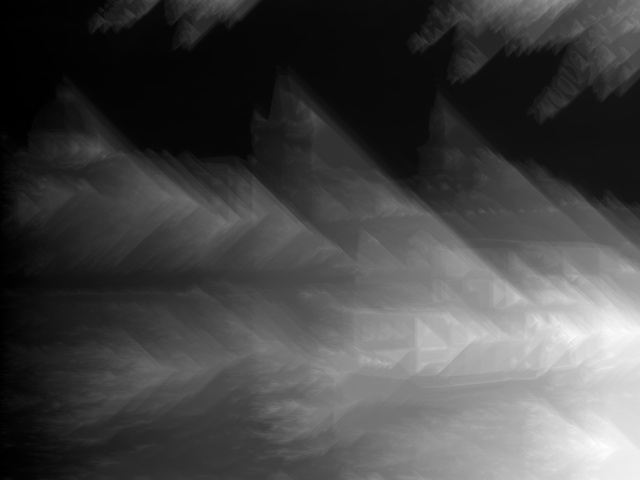

In [80]:
Gray.(cumulativeEnergyMap*0.01)

In [81]:
function find_optimal_horizontal_seam(cumulativeEnergyMap)
    (height,width)=size(cumulativeEnergyMap)
    yLocation=width
    horizontalSeam=Array{Int32,1}(width)
    minVal, xLocation=findmin(cumulativeEnergyMap[:,width])
    i=xLocation
    for j=width:-1:2
        horizontalSeam[j]=i
        if i==1
            minVal,relative_i=findmin([cumulativeEnergyMap[i,j-1], cumulativeEnergyMap[i+1, j-1]])
            i=i+relative_i-1
        elseif i==height
            minVal, relative_i=findmin([cumulativeEnergyMap[i, j-1], cumulativeEnergyMap[i-1,j-1]])
            i=i-relative_i+1
        else
            minVal, relative_i=findmin([cumulativeEnergyMap[i-1,j-1], cumulativeEnergyMap[i, j-1], cumulativeEnergyMap[i+1, j-1]])
            i=i+relative_i-2
        end
    end
    horizontalSeam[1]=i
    return horizontalSeam
end

find_optimal_horizontal_seam (generic function with 1 method)

In [82]:
horizontalSeam = find_optimal_horizontal_seam(cumulativeEnergyMap)

640-element Array{Int32,1}:
  64
  65
  64
  64
  65
  64
  65
  66
  67
  66
  67
  67
  66
   ⋮
 132
 133
 134
 135
 134
 133
 132
 131
 130
 130
 130
 130

In [83]:
function display_seam(im,seam)
    (height, width)=size(im)
    for seamIdx in 1:length(seam)
        im[seam[seamIdx],seamIdx] = 30/255
    end
end

display_seam(gray,horizontalSeam)

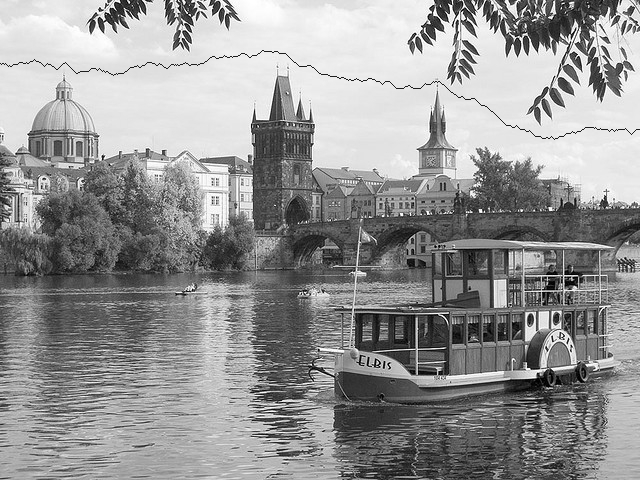

In [84]:
gray


In [85]:
1:(4)

1:4

In [86]:
function reduce_height(im,energyImage)
    (height, width)=size(im)
    
    cumulativeEnergyMap = cumulative_minimum_energy_map(energyImage)
    
    horizontalSeam = find_optimal_horizontal_seam(cumulativeEnergyMap)
    reducedColorImage = rand(RGB{Float64}, height-1, width)
    reducedEnergyImage = Array{Float64,2}(height-1,width)
    
    for j=1:width
        reducedColorImage[1:(horizontalSeam[j]-1),j]=im[1:(horizontalSeam[j]-1),j]
        reducedColorImage[horizontalSeam[j]:(height-1),j]=im[(horizontalSeam[j]+1):height,j]
        reducedEnergyImage[1:(horizontalSeam[j]-1),j]=energyImage[1:(horizontalSeam[j]-1),j]
        reducedEnergyImage[horizontalSeam[j]:(height-1),j]=energyImage[(horizontalSeam[j]+1):height,j]
    end
    return reducedColorImage,reducedEnergyImage
            
end



reduce_height (generic function with 1 method)

In [87]:
size(img)
size(energy)

(480, 640)

In [88]:
function Multiple_seam_carving_reduce_height(n, im, energy)
    if n==0
        return im, energy
    else
        (im_2, energy_2)=reduce_height(im, energy)
        n=n-1

        return Multiple_seam_carving_reduce_height(n, im_2, energy_2)
    end
end

Multiple_seam_carving_reduce_height (generic function with 1 method)

In [89]:
size(img)
#size(energy)
im, en=Multiple_seam_carving_reduce_height(50, img, energy)

(ColorTypes.RGB{Float64}[RGB{Float64}(0.862745,0.862745,0.909804) RGB{Float64}(0.858824,0.858824,0.905882) … RGB{Float64}(0.898039,0.894118,0.878431) RGB{Float64}(0.890196,0.886275,0.870588); RGB{Float64}(0.870588,0.870588,0.909804) RGB{Float64}(0.870588,0.870588,0.909804) … RGB{Float64}(0.894118,0.890196,0.87451) RGB{Float64}(0.921569,0.917647,0.901961); … ; RGB{Float64}(0.282353,0.25098,0.243137) RGB{Float64}(0.25098,0.219608,0.211765) … RGB{Float64}(0.662745,0.670588,0.666667) RGB{Float64}(0.670588,0.678431,0.67451); RGB{Float64}(0.556863,0.52549,0.517647) RGB{Float64}(0.568627,0.537255,0.529412) … RGB{Float64}(0.705882,0.713725,0.709804) RGB{Float64}(0.713725,0.721569,0.717647)], [0.0372033 1.94998 … 3.53018e75 3.81507e75; 0.0824463 1.99181 … 3.53018e75 3.81507e75; … ; 0.815177 42.2618 … 3.53018e75 3.81507e75; 1.14118 42.8697 … 3.53018e75 3.81507e75])

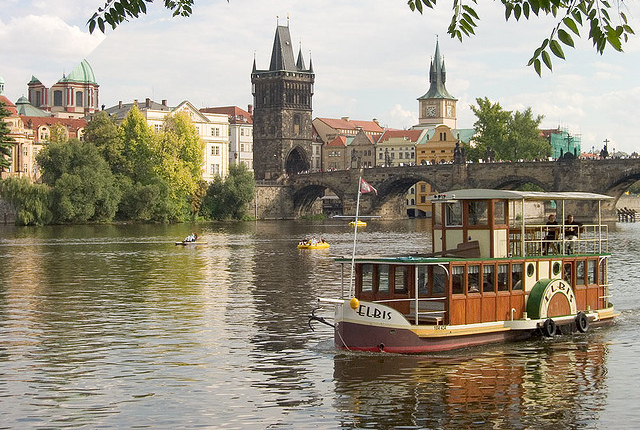

In [90]:
im

In [91]:
size(im)

(430, 640)

In [92]:
size(img)

(480, 640)